# ECG Classification using paralleled transformer model

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.2
Keras Version: 2.9.0

Python 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:41:22) [Clang 13.0.1 ]
Pandas 1.4.4
Scikit-Learn 1.1.2
GPU is available


## Loading data

In [2]:


from keras_preprocessing.sequence import pad_sequences
import keras
import tensorflow as tf
import os
import numpy as np
import json
import pandas as pd
# import kerastuner as kt
from tensorflow.keras import optimizers
from tensorflow.keras import layers
import matplotlib.pyplot as plt

%load_ext tensorboard
import datetime
!rm -rf ./logs/
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


VOCAB_SIZE = 256        #ECG Graph res

MAXLEN = 659            # length of a single ECG data string
BATCH_SIZE = 8

#-------------------------------------------------------------------------------------------------------------------
# loading training data.
train_data_II = []
for filename in sorted(os.listdir("data_training(II)")):
    if filename != ".DS_Store":       # getting rid of that annoying ".DS_Store" in OSX
        with open(f"data_training(II)/{filename}", 'rb') as f:
            # print(filename)
            data = np.load(f, allow_pickle=True)
            train_data_II.append(data)            # load data of the second lead

train_data_III = []
for filename in sorted(os.listdir("data_training(III)")):
    if filename != ".DS_Store":
        with open(f"data_training(III)/{filename}", 'rb') as f:
            # print(filename)
            data = np.load(f, allow_pickle=True)
            train_data_III.append(data)           # load data of the third lead

train_data = [train_data_II, train_data_III]

train_labels = pd.read_csv('train_labels.csv')
train_labels = train_labels['symptom']


#-------------------------------------------------------------------------------------------------------------------
# loading testing data.
test_data_II = []
for filename in sorted(os.listdir("data_testing(II)")):
    if filename != ".DS_Store":
        with open(f"data_testing(II)/{filename}", 'rb') as f:
            # print(filename)
            data = np.load(f, allow_pickle=True)
            test_data_II.append(data)             # load data of the second lead
            
test_data_III = []
for filename in sorted(os.listdir("data_testing(III)")):
    if filename != ".DS_Store":
        with open(f"data_testing(III)/{filename}", 'rb') as f:
            # print(filename)
            data = np.load(f, allow_pickle=True)
            test_data_III.append(data)          # load data of the second lead
            
test_data = [test_data_II, test_data_III]

test_labels = pd.read_csv("test_labels.csv")
test_labels = test_labels['symptom']

            
            
            
            
            
            
            
            
train_label_bin = []
for i in train_labels:
    if(i) != 0:
        train_label_bin.append(1)
    else:
        train_label_bin.append(0)
        
test_label_bin = []
for i in test_labels:
    if(i) != 0:
        test_label_bin.append(1)
    else:
        test_label_bin.append(0)



            
            

# extra_data_test = pd.read_csv("ECG_extra_data_test.csv")
# extra_data_test.pop("patients")


train_data[0]  = np.array(train_data[0])
train_data[1]  = np.array(train_data[1])
test_data[0]  = np.array(test_data[0])
test_data[1]  = np.array(test_data[1])
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)      
train_label_bin = np.array(train_label_bin)
test_label_bin = np.array(test_label_bin)    # converting all data (and labels) into ndarray for further processing





/var/folders/mw/0ghh_pb922316hk1bl56l0yr0000gn/T/ipykernel_93495/211948898.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_data[0]  = np.array(train_data[0])
/var/folders/mw/0ghh_pb922316hk1bl56l0yr0000gn/T/ipykernel_93495/211948898.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_data[1]  = np.array(train_data[1])
/var/folders/mw/0ghh_pb922316hk1bl56l0yr0000gn/T/ipykernel_93495/211948898.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

pad the data to suite the transformer based model

In [3]:
data = pad_sequences(train_data[0], maxlen=MAXLEN)
train_data[0] = data
data = pad_sequences(train_data[1], maxlen=MAXLEN)
train_data[1] = data
data = pad_sequences(test_data[0], maxlen=MAXLEN)
test_data[0] = data
data = pad_sequences(test_data[1], maxlen=MAXLEN)
test_data[1] = data

tf.convert_to_tensor(train_data[0])
tf.convert_to_tensor(train_data[1])
tf.convert_to_tensor(test_data[0])
tf.convert_to_tensor(test_data[1])

Metal device set to: Apple M1


2022-10-10 21:08:53.157529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-10 21:08:53.157623: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<tf.Tensor: shape=(83, 659), dtype=int32, numpy=
array([[  0,   0,   0, ..., 141,  35,   9],
       [  0,   0,   0, ...,  37,  26,  22],
       [  0,   0,   0, ...,  61,  61,  56],
       ...,
       [  0,   0,   0, ...,  74,  82,  82],
       [  0,   0,   0, ...,  63,  66,  66],
       [  0,   0,   0, ...,  31,   3,   7]], dtype=int32)>

## Create Tensorflow Dataset

In [4]:
# train_dataset_II = tf.data.Dataset.from_tensor_slices(train_data[0]) \
#     .shuffle(8000).batch(BATCH_SIZE)

# train_dataset_III = tf.data.Dataset.from_tensor_slices(train_data[1]) \
#     .shuffle(8000).batch(BATCH_SIZE)
    

# train_data = [train_dataset_II, train_data_III]

## Build Model
In this project, a transformer based model is used for classification. The model consists two transformer encoder each conected with a dense network. The output of the two dense network will than be fed into a larger network to calculate the final result. This configuration should be able to analysis two sets of data simultaneously, in this case, the second lead and the third lead of a ECG data.     
Transformer encoders are used as many researches showed that they are powerful tools when processing time series. For data like ECG, temporality is important and rnn models including transformers are just designed for that since those highly time dependent works cannot be simply achieved by networks such as CNN.
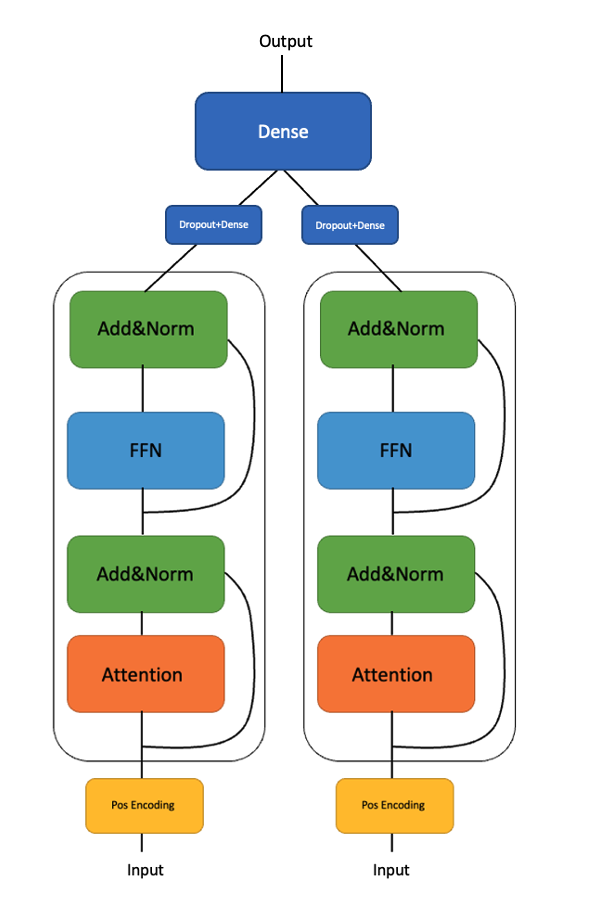


In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [6]:
def build_LSTM():
    input_shape = (10, 400)
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE, 32),      # This will tell keras to creat a vocab vector space of 32 dimension (outputs) and vocab_amount(vetors) as "VOCAB_SIZE" 
        # tf.keras.layers.LSTM(32, return_sequences=True),                       
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation="relu")  
    ])
    return model

def build_Transformer():
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(MAXLEN,))
    embedding_layer = TokenAndPositionEmbedding(MAXLEN, VOCAB_SIZE, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    outputs = transformer_block(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



def build_Dense():
    model = tf.keras.Sequential([
        
        tf.keras.layers.Input(shape=(10,)),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu')
    ])
    return model

In [7]:
rnn = build_Transformer()

rnn_2 = build_Transformer()

In [8]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=7):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [9]:
learning_rate = CustomSchedule(32)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

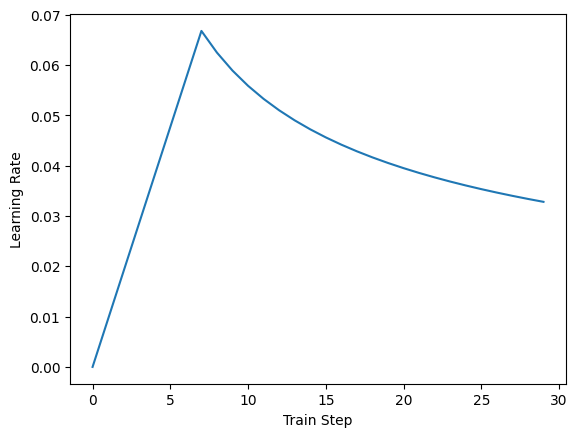

In [10]:
plt.plot(learning_rate(tf.range(30, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Training
After trying to directly train the model, it showed that the model stopped converging at around 20~25 epochs and settled at some local optimas, causing vague or incorrect predictions. According to the article “Understanding the Difficulty of Training Transformers” on “Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing”, the variance of gradient of bottom layers in transformer encoders (with Post-LN architecture) is greater than the ones of top layers. Therefore, transformer encoders do not suffer from gradient vanishing. From this, it could be concluded that the issue of stop converging is mainly because of the great depth of the model and transfer learning should be used in the training.

### Training-Part-1
In this Part of training, the 2 transformer(encoder) model will first learn to distinguash the difference between normal or healthy ECGs and bad ECGs.    
This could help transformer encoders learn to recognize shape of ECG and their features.

In [11]:
model = tf.keras.layers.concatenate([rnn.output])
x = layers.GlobalAveragePooling1D()(model)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs=rnn.input, outputs=x)



model.compile(# optimizer=optimizers.RMSprop(learning_rate=0.005),
                optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


history = model.fit(
                    x=train_data[0], y=train_label_bin,
                    validation_data=(test_data[0], test_label_bin),
                    epochs=25,batch_size=BATCH_SIZE,
                    callbacks=[tensorboard_callback],
                   )

Layer TokenAndPositionEmbedding has arguments ['self', 'maxlen', 'vocab_size', 'embed_dim']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/25


2022-10-10 21:08:53.632058: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/fengqijie/miniforge3/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-10-10 21:08:54.208175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.8475

2022-10-10 21:08:58.242436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 5s 95ms/step - loss: 0.4868 - accuracy: 0.8475 - val_loss: 0.6155 - val_accuracy: 0.8072
Epoch 2/25
43/43 [==============================] - 3s 79ms/step - loss: 0.4327 - accuracy: 0.8592 - val_loss: 0.5407 - val_accuracy: 0.8072
Epoch 3/25
43/43 [==============================] - 3s 77ms/step - loss: 0.4191 - accuracy: 0.8592 - val_loss: 0.4902 - val_accuracy: 0.8072
Epoch 4/25
43/43 [==============================] - 3s 76ms/step - loss: 0.4184 - accuracy: 0.8592 - val_loss: 0.4982 - val_accuracy: 0.8072
Epoch 5/25
43/43 [==============================] - 3s 77ms/step - loss: 0.4171 - accuracy: 0.8592 - val_loss: 0.5027 - val_accuracy: 0.8072
Epoch 6/25
43/43 [==============================] - 3s 77ms/step - loss: 0.4126 - accuracy: 0.8592 - val_loss: 0.4870 - val_accuracy: 0.8072
Epoch 7/25
43/43 [==============================] - 3s 77ms/step - loss: 0.4145 - accuracy: 0.8592 - val_loss: 0.4850 - val_accuracy: 0.8072
Epoch 8/25
43/43 [======

2022-10-10 21:10:20.521107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 125ms/step


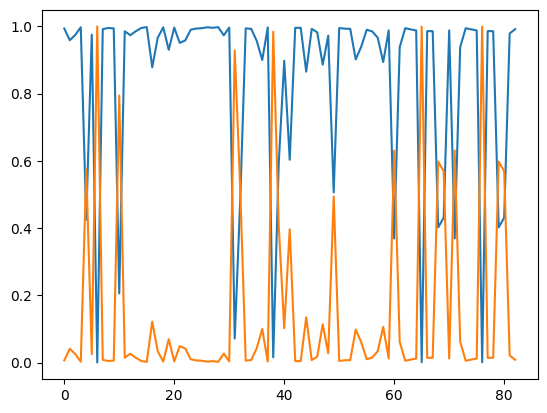

In [12]:
prediction = model.predict([test_data[0]])
plt.plot(prediction)

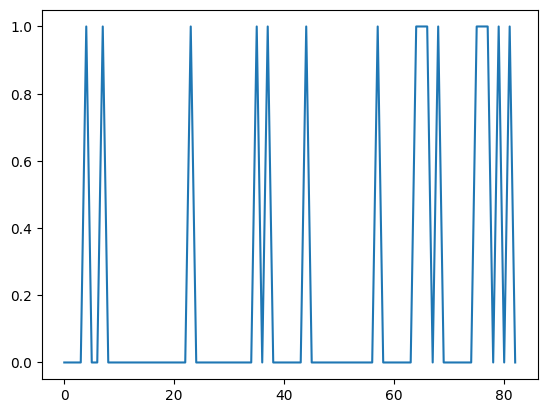

In [13]:
plt.plot(test_label_bin)

In [14]:
model = tf.keras.layers.concatenate([rnn_2.output])
x = layers.GlobalAveragePooling1D()(model)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs=rnn_2.input, outputs=x)



model.compile(# optimizer=optimizers.RMSprop(learning_rate=0.005),
                optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


history = model.fit(
                    x=train_data[1], y=train_label_bin,
                    validation_data=(test_data[1], test_label_bin),
                    epochs=25,batch_size=BATCH_SIZE,
                    callbacks=[tensorboard_callback],
                   )

Layer TokenAndPositionEmbedding has arguments ['self', 'maxlen', 'vocab_size', 'embed_dim']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/25


2022-10-10 21:10:21.686958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8446

2022-10-10 21:10:26.367278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 6s 112ms/step - loss: 0.4806 - accuracy: 0.8446 - val_loss: 0.4926 - val_accuracy: 0.8072
Epoch 2/25
43/43 [==============================] - 4s 89ms/step - loss: 0.4049 - accuracy: 0.8592 - val_loss: 0.5141 - val_accuracy: 0.8072
Epoch 3/25
43/43 [==============================] - 4s 85ms/step - loss: 0.3652 - accuracy: 0.8592 - val_loss: 0.5737 - val_accuracy: 0.8072
Epoch 4/25
43/43 [==============================] - 4s 86ms/step - loss: 0.3804 - accuracy: 0.8592 - val_loss: 0.5152 - val_accuracy: 0.8072
Epoch 5/25
43/43 [==============================] - 4s 86ms/step - loss: 0.3533 - accuracy: 0.8592 - val_loss: 0.5043 - val_accuracy: 0.8072
Epoch 6/25
43/43 [==============================] - 4s 85ms/step - loss: 0.3296 - accuracy: 0.8710 - val_loss: 0.5481 - val_accuracy: 0.8072
Epoch 7/25
43/43 [==============================] - 4s 93ms/step - loss: 0.2929 - accuracy: 0.8622 - val_loss: 0.6270 - val_accuracy: 0.7108
Epoch 8/25
43/43 [=====

2022-10-10 21:11:54.385593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 127ms/step


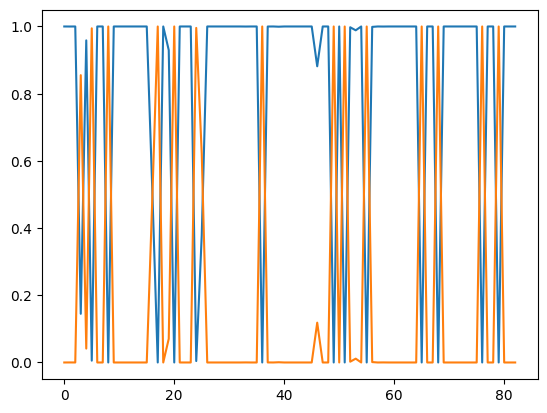

In [15]:
prediction = model.predict(test_data[1])
plt.plot(prediction)

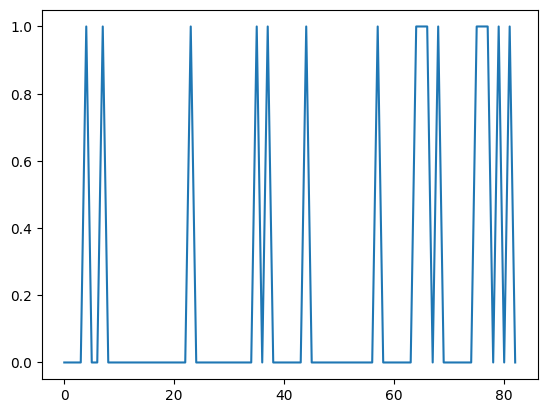

In [16]:
plt.plot(test_label_bin)

### Training-Part-2    
In this part of training, the rnn part will be rip out of the trained `model`, then it will be add to another model to do classifications.

In [17]:
rnn_classifier1 = tf.keras.layers.concatenate([rnn.output])
x = layers.GlobalAveragePooling1D()(rnn_classifier1)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(5, activation="relu")(x)
rnn_classifier1 = tf.keras.Model(inputs=rnn.input, outputs=x)



rnn_classifier1.compile(# optimizer=optimizers.RMSprop(learning_rate=0.005),
                optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


history = rnn_classifier1.fit(
                    x=train_data[0], y=train_labels,
                    validation_data=(test_data[0], test_labels),
                    epochs=30,batch_size=BATCH_SIZE,
                    callbacks=[tensorboard_callback],
                   )

Layer TokenAndPositionEmbedding has arguments ['self', 'maxlen', 'vocab_size', 'embed_dim']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/30


2022-10-10 21:11:55.649275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.8592

2022-10-10 21:12:00.625222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 6s 122ms/step - loss: 0.5133 - accuracy: 0.8592 - val_loss: 1.0622 - val_accuracy: 0.7831
Epoch 2/30
43/43 [==============================] - 4s 91ms/step - loss: 0.2174 - accuracy: 0.9326 - val_loss: 1.0809 - val_accuracy: 0.7590
Epoch 3/30
43/43 [==============================] - 4s 88ms/step - loss: 0.1864 - accuracy: 0.9413 - val_loss: 1.1699 - val_accuracy: 0.7229
Epoch 4/30
43/43 [==============================] - 4s 88ms/step - loss: 0.1704 - accuracy: 0.9443 - val_loss: 1.1308 - val_accuracy: 0.7470
Epoch 5/30
43/43 [==============================] - 4s 86ms/step - loss: 0.1474 - accuracy: 0.9531 - val_loss: 1.1520 - val_accuracy: 0.7590
Epoch 6/30
43/43 [==============================] - 4s 86ms/step - loss: 0.1369 - accuracy: 0.9560 - val_loss: 1.1867 - val_accuracy: 0.7470
Epoch 7/30
43/43 [==============================] - 4s 87ms/step - loss: 0.1393 - accuracy: 0.9531 - val_loss: 1.2178 - val_accuracy: 0.7590
Epoch 8/30
43/43 [=====

2022-10-10 21:13:47.353000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 149ms/step


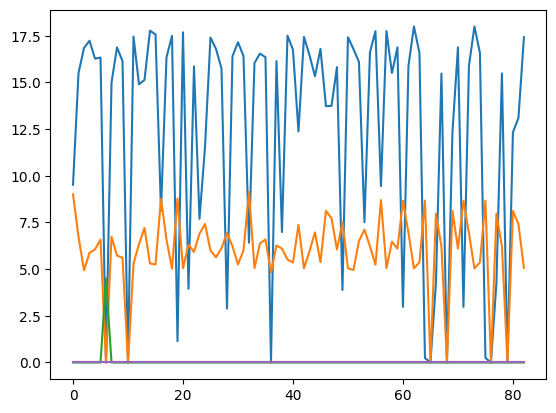

In [18]:
prediction = rnn_classifier1.predict(test_data[0])
plt.plot(prediction)

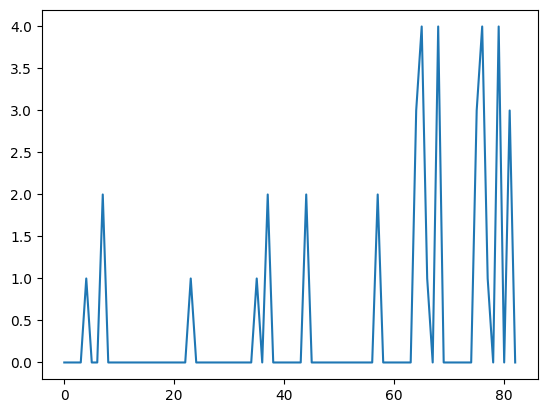

In [19]:
plt.plot(test_labels)

In [20]:
rnn_classifier2 = tf.keras.layers.concatenate([rnn_2.output])
x = layers.GlobalAveragePooling1D()(rnn_classifier2)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(5, activation="relu")(x)
rnn_classifier2 = tf.keras.Model(inputs=rnn_2.input, outputs=x)



rnn_classifier2.compile(# optimizer=optimizers.RMSprop(learning_rate=0.005),
                optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


history = rnn_classifier2.fit(
                    x=train_data[1], y=train_labels,
                    validation_data=(test_data[1], test_labels),
                    epochs=30,batch_size=BATCH_SIZE,
                    callbacks=[tensorboard_callback],
                   )

Layer TokenAndPositionEmbedding has arguments ['self', 'maxlen', 'vocab_size', 'embed_dim']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/30


2022-10-10 21:13:48.547755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.8270

2022-10-10 21:13:54.187209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 7s 132ms/step - loss: 0.4747 - accuracy: 0.8270 - val_loss: 1.4363 - val_accuracy: 0.6988
Epoch 2/30
43/43 [==============================] - 4s 89ms/step - loss: 0.1801 - accuracy: 0.9355 - val_loss: 1.5287 - val_accuracy: 0.6867
Epoch 3/30
43/43 [==============================] - 4s 87ms/step - loss: 0.1523 - accuracy: 0.9501 - val_loss: 1.6112 - val_accuracy: 0.6386
Epoch 4/30
43/43 [==============================] - 4s 88ms/step - loss: 0.1567 - accuracy: 0.9384 - val_loss: 1.5952 - val_accuracy: 0.7349
Epoch 5/30
43/43 [==============================] - 4s 85ms/step - loss: 0.1332 - accuracy: 0.9589 - val_loss: 1.4781 - val_accuracy: 0.5783
Epoch 6/30
43/43 [==============================] - 4s 87ms/step - loss: 0.1193 - accuracy: 0.9677 - val_loss: 1.7456 - val_accuracy: 0.6386
Epoch 7/30
43/43 [==============================] - 4s 84ms/step - loss: 0.0926 - accuracy: 0.9824 - val_loss: 1.6568 - val_accuracy: 0.6506
Epoch 8/30
43/43 [=====

2022-10-10 21:15:40.743519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 169ms/step


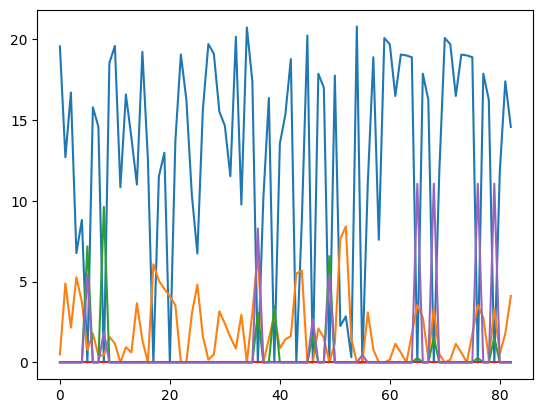

In [21]:
prediction = rnn_classifier2.predict(test_data[1])
plt.plot(prediction)

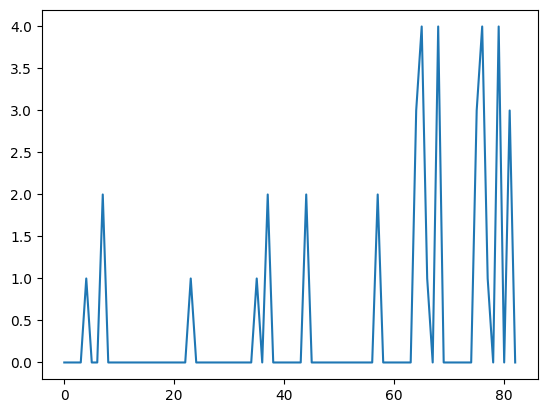

In [22]:
plt.plot(test_labels)

### Training-Part-3
In the third part of training, the final network will be assambled and trained

In [23]:
combinedInput = tf.keras.layers.concatenate([rnn_classifier1.output, rnn_classifier2.output])
x = tf.keras.layers.Dense(8, activation="relu")(combinedInput)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

In [24]:
model = tf.keras.Model(inputs=[rnn_classifier1.input, rnn_classifier2.input], outputs=x)

model.compile(# optimizer=optimizers.RMSprop(learning_rate=0.005),
                optimizer=optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history = model.fit(
                    x=[train_data[0], train_data[1]], y=train_labels,
                    validation_data=([test_data[0], test_data[1]], test_labels),
                    epochs=10, batch_size=BATCH_SIZE,
                    callbacks=[tensorboard_callback],
                   )


Layer TokenAndPositionEmbedding has arguments ['self', 'maxlen', 'vocab_size', 'embed_dim']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10


2022-10-10 21:15:42.553410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 1.2096 - accuracy: 0.7067

2022-10-10 21:15:51.885808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 12s 217ms/step - loss: 1.2096 - accuracy: 0.7067 - val_loss: 1.7170 - val_accuracy: 0.7470
Epoch 2/10
43/43 [==============================] - 6s 140ms/step - loss: 0.2310 - accuracy: 0.9091 - val_loss: 1.4287 - val_accuracy: 0.7711
Epoch 3/10
43/43 [==============================] - 6s 133ms/step - loss: 0.1627 - accuracy: 0.9296 - val_loss: 1.4990 - val_accuracy: 0.7470
Epoch 4/10
43/43 [==============================] - 6s 131ms/step - loss: 0.1394 - accuracy: 0.9355 - val_loss: 1.6202 - val_accuracy: 0.7349
Epoch 5/10
43/43 [==============================] - 6s 132ms/step - loss: 0.1115 - accuracy: 0.9619 - val_loss: 1.5579 - val_accuracy: 0.7349
Epoch 6/10
43/43 [==============================] - 6s 133ms/step - loss: 0.0776 - accuracy: 0.9883 - val_loss: 1.6655 - val_accuracy: 0.7470
Epoch 7/10
43/43 [==============================] - 6s 133ms/step - loss: 0.0395 - accuracy: 0.9912 - val_loss: 1.8801 - val_accuracy: 0.7229
Epoch 8/10
43/43

2022-10-10 21:16:44.510491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 347ms/step


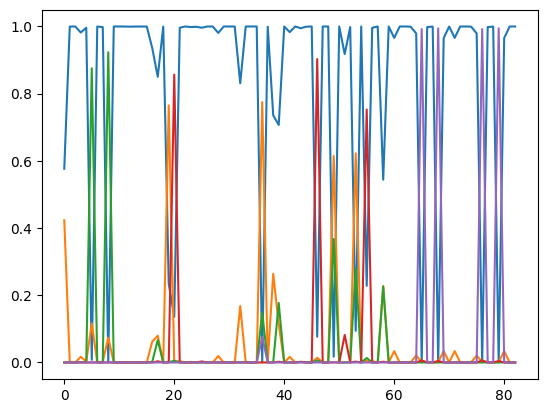

In [25]:
prediction = model.predict(test_data)
plt.plot(prediction)

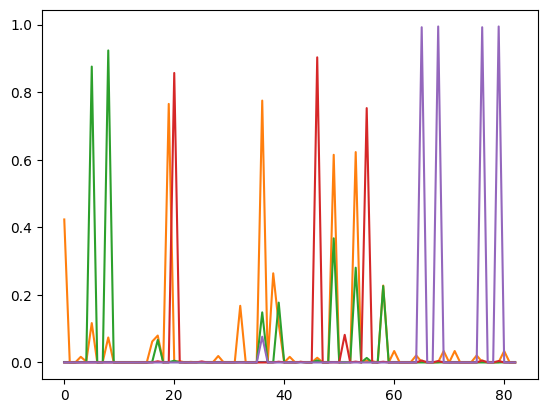

In [26]:
for i in range(len(prediction)):
    prediction[i][0] = 0
    
plt.plot(prediction)

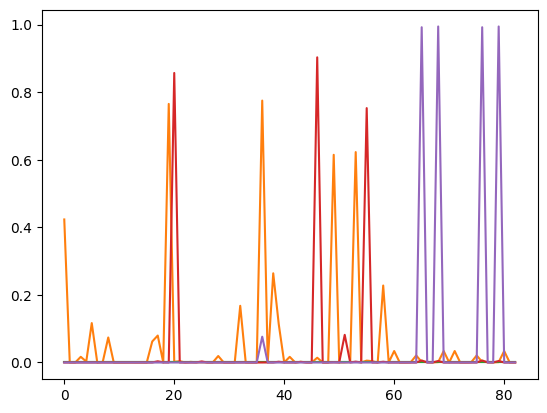

In [27]:
for i in range(len(prediction)):
    prediction[i][2]=0
    
plt.plot(prediction)

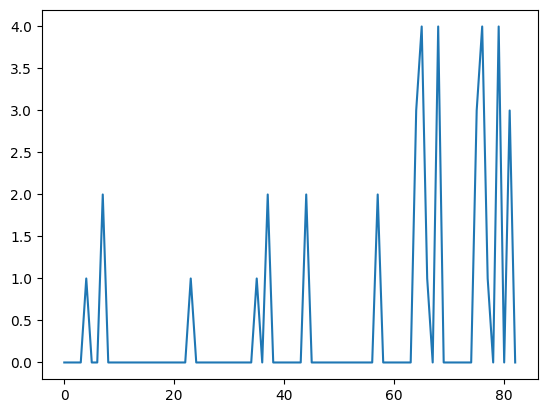

In [28]:
plt.plot(test_labels)

11/11 [==============================] - 2s 205ms/step


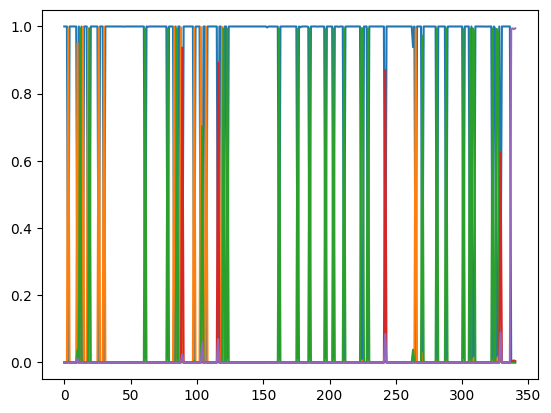

In [29]:
prediction = model.predict(train_data)
plt.plot(prediction)

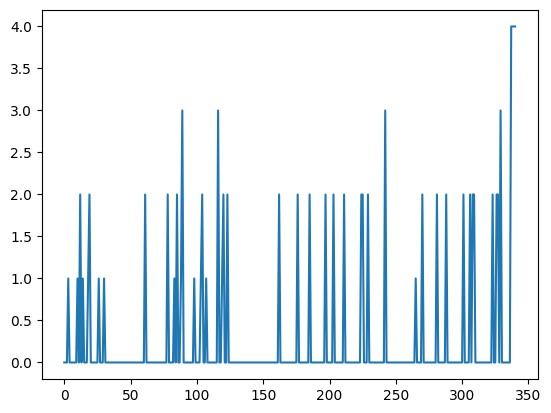

In [30]:
plt.plot(train_labels)

In [31]:
for i in range(len(prediction)):
    print(i, prediction[i])

0 [9.9993789e-01 5.4804939e-05 3.0347508e-06 4.3365476e-06 3.6313389e-19]
1 [9.9992359e-01 7.3052150e-05 3.2169733e-06 1.4113584e-07 1.0392644e-20]
2 [9.9998868e-01 2.4438102e-06 2.8326807e-07 8.6479331e-06 1.8790880e-21]
3 [4.0412107e-03 9.9378997e-01 2.1687441e-03 9.2099208e-09 3.9882263e-08]
4 [9.9998927e-01 5.7666630e-06 9.4518640e-07 3.9969977e-06 3.4370186e-21]
5 [9.9997866e-01 3.3551871e-06 5.0871148e-07 1.7447825e-05 8.5267862e-21]
6 [9.9999082e-01 2.0091516e-06 2.0939478e-07 6.9442676e-06 1.2332465e-21]
7 [9.9999356e-01 2.9825737e-06 2.1419592e-07 3.2611872e-06 6.1008589e-22]
8 [9.9997985e-01 1.7874618e-05 1.2910880e-06 1.0045184e-06 4.6387820e-21]
9 [9.9999058e-01 7.4693166e-06 4.5494312e-07 1.5297911e-06 1.7403973e-21]
10 [1.3845781e-03 9.5018679e-01 3.7414342e-02 1.7423926e-06 1.1012618e-02]
11 [9.9999022e-01 4.4057820e-06 3.4715032e-07 5.0619742e-06 3.8371253e-21]
12 [2.8862787e-06 5.0408221e-03 9.9486983e-01 5.8318234e-10 8.6462082e-05]
13 [9.9996114e-01 3.0361136e-06 6.8

Now the training of model is complete.     
From plots generated in the 4 cells above, the features of the test label plot can be slightly seen from the plot of the predictions. This means that the model is capable of "learning" from the training dataset and reflect to data it has never seen. Considering that the amount of training data is quite small, (only around 300 and in those data, the mount of unhealthy samples is only at 48), inevitable incorrect predictions sometimes occur as the model might not be able to find the hidden patterns. However, looking at the prediction on training data, we can say that the "learning" process of the model is farily successful, showing the potential of such paralleled transformer model and its training method.

## Conclusion and discussion   
From the plots and historties above, we have seen feasibility of classifying multi-lead ECG using such paralleled transformer model. Moreover, beside generating categorical outputs, this sturcture is also capable of outputting encoded latent representation of the input data. If concatenated with other networks, this model can act like a pre-analysing layer to provide a smaller size calculatable representation to the next layer of network. Meanwhile, the (self) transfer learning trick can be applyed when the dealing with deep transformer encoder based networks.